<a href="https://colab.research.google.com/github/LauraSchellekens/TM10007_-private_-group/blob/Manon_feature_selection/Feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git
!pip install sklearn numpy matplotlib

In [0]:
# General packages not sure anymore what I'm actually using lol
import numpy as np 
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import impute
from sklearn import datasets, linear_model
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn import feature_selection 
from sklearn import feature_selection 
from sklearn.model_selection import train_test_split

In [20]:
# Data loading functions. Uncomment the one you want to use
from adni.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


X = data.drop('label', axis=1) # All data without column 'label'
Y = data['label'] 
Y.replace(('AD', 'CN'), (1, 0), inplace=True) # convert AD and CN to 1 and 0

The number of samples: 855
The number of columns: 268


In [21]:
# split into train (70%) and test (30%) set

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(598, 267) (598,)
(257, 267) (257,)


In [22]:
# Preprocessing: drop feature if too many missing values

X_train = X_train.replace(0, np.NaN)                                    # replace 0 with NaN
missing_per_feature_train = X_train.isnull().sum()                      # gives the amount of missing values (NaN) per feature
pct_null_train = missing_per_feature_train / len(X_train)               # gives percentage of missing values per feature
missing_features_train = pct_null_train[pct_null_train > 0.40].index    # gives features with more than 40% missing values
X_train.drop(missing_features_train, axis=1, inplace=True)              # remove feature if more than 40% missing values

X_test = X_test.replace(0, np.NaN)                                      # replace 0 with NaN
missing_per_feature_test = X_test.isnull().sum()                        # gives the amount of missing values (NaN) per feature
pct_null_test = missing_per_feature_test / len(X_test)                  # gives percentage of missing values per feature
missing_features_test = pct_null_test[pct_null_train > 0.40].index      # gives features with more than 40% missing values
X_test.drop(missing_features_test, axis=1, inplace=True)                # remove feature if more than 40% missing values

missing_per_feature_max_train = max(X_train.isnull().sum())             # gives the maximum amount of missing values (NaN) per feature AFTER dropping incomplete features
missing_per_feature_max_test = max(X_test.isnull().sum())               # gives the maximum amount of missing values (NaN) per feature AFTER dropping incomplete features

print(missing_per_feature_max_train)
print (X_train.shape, y_train.shape)

92
(598, 261) (598,)


In [23]:
# Preprocessing:  impute missing values (fill missing)

imputer = impute.SimpleImputer(strategy='mean')       # imputer with mean 
X_train_imp = imputer.fit_transform(X_train)          # impute  
X_train_imp = pd.DataFrame(data=X_train_imp, index=[X_train.index], columns=[X_train.columns])  # turn created np.array back to pandas df

X_test_imp = imputer.fit_transform(X_test)            # impute  
X_test_imp = pd.DataFrame(data=X_test_imp, index=[X_test.index], columns=[X_test.columns])      # turn created np.array back to pandas df

type(X_train_imp)


pandas.core.frame.DataFrame

In [24]:
# Preprocessing: scaling either standard or robust (removes median and scales data according to quantile range) 

scaler = preprocessing.StandardScaler()
scaler.fit_transform(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp)        # scaling the training data

scaler.fit_transform(X_test_imp)
X_test_scaled = scaler.transform(X_test_imp)          # scaling the test data

X_train_scaled = pd.DataFrame(data=X_train_scaled, index=[X_train.index], columns=[X_train.columns])  # turn created np.array back to pandas df
X_test_scaled = pd.DataFrame(data=X_test_scaled, index=[X_test.index], columns=[X_test.columns])      # turn created np.array back to pandas df

print(len(X_train_scaled))

598


In [0]:
# Code for feature selection
'''
First determine the best amount of features
'''

# Create the RFE object and compute a cross-validated score.
svc = svm.SVC(kernel="linear", random_state= None)
X= X_train_scaled
y= y_train

In [25]:


# classifications
rfecv = feature_selection.RFECV(
    estimator=svc, step=1, 
    cv=model_selection.StratifiedKFold(n_splits=5),
    scoring='roc_auc')
rfecv.fit(X, y)
feature_selection.RFECV()
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


NameError: ignored

In [14]:
# Code for feature selection
'''
With the amount of features desired known, find the best performing features
'''
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
 
#apply SelectKBest class to extract top ... best features
bestfeatures = SelectKBest(score_func= f_classif, k=32) # k= number of desired features
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(32,'Score'))  #print ... best features 


                                            Specs       Score
1                                   (hf_entropy,)  540.044084
2                                  (hf_kurtosis,)  404.552131
11                                      (hf_std,)  364.426795
8                            (hf_quartile_range,)  353.618383
218                          (tf_LBP_std_R3_P12,)  349.047098
99   (tf_GLRLM_GrayLevelNonUniformityNormalized,)  282.934329
100                 (tf_GLRLM_GrayLevelVariance,)  281.213410
111                  (tf_GLRLM_ShortRunEmphasis,)  280.321212
222                        (tf_NGTDM_Complexity,)  279.807015
113      (tf_GLRLM_ShortRunLowGrayLevelEmphasis,)  257.356041
73              (phasef_phasesym_entropy_WL3_N5,)  238.773800
134                      (tf_Gabor_0.05A0.0skew,)  226.395155
6                                       (hf_min,)  207.733146
150                     (tf_Gabor_0.05A2.36mean,)  188.879981
9                                     (hf_range,)  187.038136
79      

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [208 211 212 213] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[[-4.11856980e+00 -7.14702295e+00  1.33234957e+00 ... -2.38197387e-16
   6.91747472e-17  8.42991185e-17]
 [ 1.93179246e+00  6.16333798e+00 -2.91606520e+00 ... -2.70867411e-16
  -6.01890336e-17 -1.77839383e-18]
 [-4.20471471e+00 -4.83733975e+00  9.14969231e+00 ...  2.43031242e-16
   2.55357464e-16  2.43860655e-17]
 ...
 [-1.12099871e+00  5.33260476e+00  3.06126764e+00 ...  1.03301762e-16
  -1.38566875e-16  4.23673620e-17]
 [ 9.78384698e+00  8.46543191e+00 -7.76004243e+00 ... -1.56553417e-16
  -1.49190666e-16  7.71375638e-18]
 [-1.81019085e+00 -7.00050072e+00  3.67581995e+00 ... -1.42766384e-16
   7.02725769e-17  5.22525821e-17]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


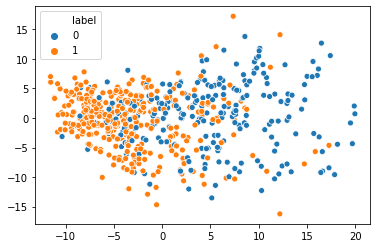

In [27]:
# Code for PCA
from sklearn import decomposition
import seaborn
pca = decomposition.PCA(n_components=260) #blabla comment test
X= X_train_scaled
test= X_test_scaled
pca.fit(X)
X_train_pca = pca.transform(X)
y= y_train
# X_pca= pd.DataFrame(data= X_train_pca, index=[X.index], columns=[X.columns])
X_test_pca = pca.transform(test)
print(X_train_pca)
#X_train_scaled = pd.DataFrame(data=X_train_scaled, index=[X_train.index], columns=[X_train.columns])
seaborn.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y)

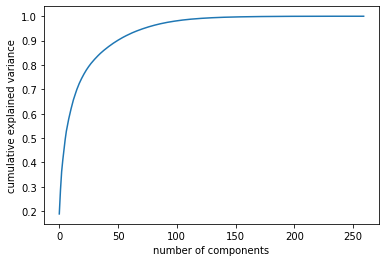

In [28]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');